In [151]:
import matplotlib
%matplotlib inline
from ggplot import * 
import pandas as pd
import seaborn as sbn
import sqlalchemy
import numpy as np

# Global Temperatures data set

This data set contains information about temperatures around the world. We can look at cities, major cities, countries, or just global temperatures. 

Let's first take a look at something simple, like finding the change in temperature globally.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  app.launch_new_instance()


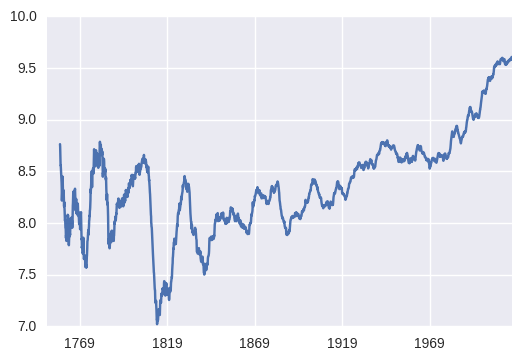

In [268]:
GlobalTemp = pd.read_csv('GlobalTemperatures.csv')
GlobalTemp=GlobalTemp.set_index(GlobalTemp.dt)
GlobalTemp.index=GlobalTemp.index.to_datetime()
GlobalTemp = GlobalTemp[GlobalTemp.index.year > 1700]['LandAverageTemperature']
GlobalTemp = GlobalTemp.rolling(window=60).mean()

GlobalTemp.plot(x=GlobalTemp.index)

The beginning of this graph shows how 'uncertain' the data is between the 1700's and 1800's. 

Next, let's find out if there are any trends within individual seasons globally. GGplot can create a nice graph for this. 

In [152]:
gtemp = pd.read_csv('GlobalTemperatures.csv')

In [271]:
gtemp = gtemp[['dt', 'LandAverageTemperature']]

#create new columns, translating 'dt' to a year, and a month
gtemp['dt'] = pd.to_datetime(gtemp['dt'])
gtemp['year'] = gtemp['dt'].map(lambda x: x.year)
gtemp['month'] = gtemp['dt'].map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

#find year range
min_year = gtemp['year'].min()
max_year = gtemp['year'].max()
years = range(min_year, max_year + 1)

#we can apply get_season function to the month column, and put the results in a new 'seasons' column
gtemp['season'] = gtemp['month'].apply(get_season)

spring_temps = []
summer_temps = []
autumn_temps = []
winter_temps = []

#for every year, we'll slice off only that year's data, then we can slice off each season, find its mean, and add it to 
#the corresponding list
for year in years:
    curr_years_data = gtemp[gtemp['year'] == year]
    spring_temps.append(curr_years_data[curr_years_data['season'] == 'spring']['LandAverageTemperature'].mean())
    summer_temps.append(curr_years_data[curr_years_data['season'] == 'summer']['LandAverageTemperature'].mean())
    autumn_temps.append(curr_years_data[curr_years_data['season'] == 'autumn']['LandAverageTemperature'].mean())
    winter_temps.append(curr_years_data[curr_years_data['season'] == 'winter']['LandAverageTemperature'].mean())
#here is what the table looks like
gtemp.head()

,dt,LandAverageTemperature,year,month,season
0,1750-01-01,3.034,1750,1,winter
1,1750-02-01,3.083,1750,2,winter
2,1750-03-01,5.626,1750,3,spring
3,1750-04-01,8.490,1750,4,spring
4,1750-05-01,11.573,1750,5,spring


In [272]:
#GGplot wants a dataframe 
seasons = pd.DataFrame(
    {'spring': spring_temps,
     'summer': summer_temps,
     'autumn': autumn_temps,
     'winter': winter_temps,
    })
#add a years column from the years list
seasons['year'] = years
seasons.head()

,autumn,spring,summer,winter,year
0,8.890000,8.563000,14.518333,2.963000,1750
1,10.673000,6.735000,14.116000,1.729000,1751
2,7.587000,7.035500,NaN,2.717000,1752
3,9.212333,8.627333,14.608333,1.104333,1753
4,8.957333,9.074333,14.208333,1.637333,1754


In [273]:
#use the melt() function to let ggplot graph multiple lines using the 'variable' column
gg = pd.melt(seasons, id_vars="year")
gg.head()

,year,variable,value
0,1750,autumn,8.890000
1,1751,autumn,10.673000
2,1752,autumn,7.587000
3,1753,autumn,9.212333
4,1754,autumn,8.957333


/usr/local/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


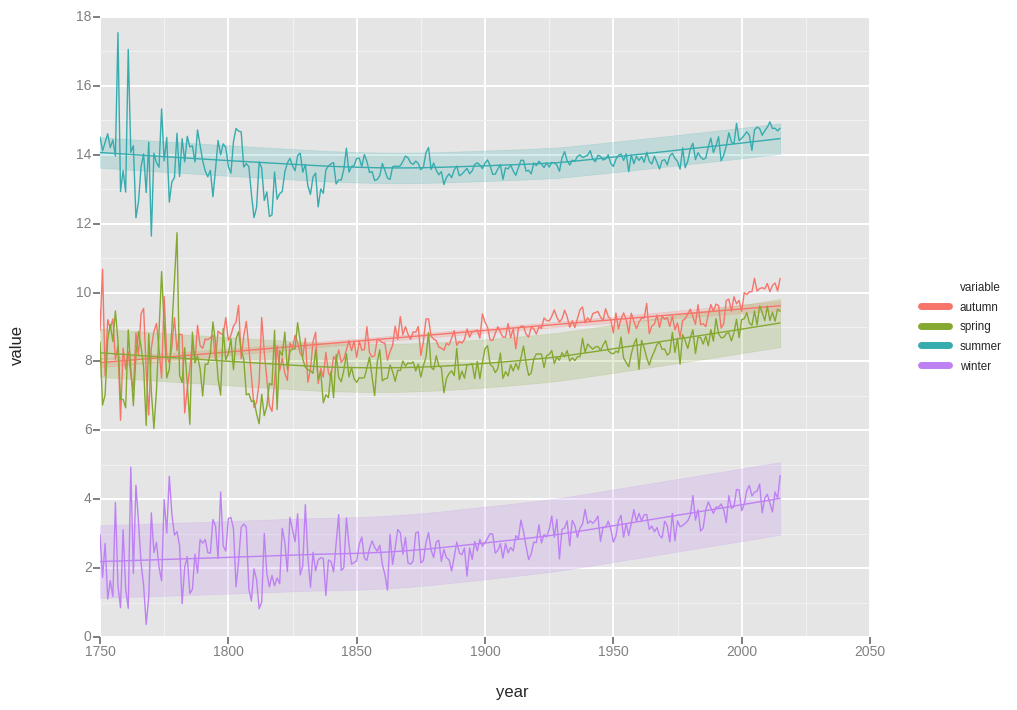

<ggplot: (8751971587006)>

In [274]:
ggplot(gg, aes(x='year', y='value', color='variable')) + \
    geom_line() + stat_smooth(fullrange= 'TRUE')

This graph above shows some trends globally, splitting up the year by seasons according to the northern hemisphere. 
What if we want to see trends just in the northern, or southern hemisphere?

We can do that by looking at the latitude column in the cities dataset. 

In [277]:
city = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [278]:
city.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [279]:
#make a list of the latitude column, find out if it's an N, if so, it's in the northern hemisphere
north = []    
lats = city['Latitude'].tolist()
for i in lats:
    if i[-1] == 'N':
        north.append('True')
    else:
        north.append('False')

#new df with new 'north' column
hemisphere = pd.DataFrame({'dt':city.dt,'AverageTemperature':city.AverageTemperature,\
                           'City':city.City,'Country':city.Country,'north': north})
#nh is northern hempishphere, sh is southern
nh = hemisphere[hemisphere['north']=='True']
sh = hemisphere[hemisphere['north']=='False']

In [280]:
nh.head()

,AverageTemperature,City,Country,dt,north
0,6.068,Århus,Denmark,1743-11-01,True
1,NaN,Århus,Denmark,1743-12-01,True
2,NaN,Århus,Denmark,1744-01-01,True
3,NaN,Århus,Denmark,1744-02-01,True
4,NaN,Århus,Denmark,1744-03-01,True


In [281]:
sh.head()

,AverageTemperature,City,Country,dt,north
78638,21.432,Adelaide,Australia,1841-01-01,False
78639,22.087,Adelaide,Australia,1841-02-01,False
78640,18.859,Adelaide,Australia,1841-03-01,False
78641,15.033,Adelaide,Australia,1841-04-01,False
78642,12.864,Adelaide,Australia,1841-05-01,False


# The next several blocks of code resemble exactly what was done before, just on split data between the hemispheres. 

In [212]:
nh = nh[['dt', 'AverageTemperature']]
nh['dt'] = pd.to_datetime(nh['dt'])
nh['year'] = nh['dt'].map(lambda x: x.year)
nh['month'] = nh['dt'].map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
min_year = nh['year'].min()
max_year = nh['year'].max()
years = range(min_year, max_year + 1)

nh['season'] = nh['month'].apply(get_season)

spring_temps = []
summer_temps = []
autumn_temps = []
winter_temps = []

for year in years:
    curr_years_data = nh[nh['year'] == year]
    spring_temps.append(curr_years_data[curr_years_data['season'] == 'spring']['AverageTemperature'].mean())
    summer_temps.append(curr_years_data[curr_years_data['season'] == 'summer']['AverageTemperature'].mean())
    autumn_temps.append(curr_years_data[curr_years_data['season'] == 'autumn']['AverageTemperature'].mean())
    winter_temps.append(curr_years_data[curr_years_data['season'] == 'winter']['AverageTemperature'].mean())

nh.head()

,dt,AverageTemperature,year,month,season
0,1743-11-01,6.068,1743,11,autumn
1,1743-12-01,NaN,1743,12,winter
2,1744-01-01,NaN,1744,1,winter
3,1744-02-01,NaN,1744,2,winter
4,1744-03-01,NaN,1744,3,spring


In [213]:
seasons = pd.DataFrame(
    {'spring': spring_temps,
     'summer': summer_temps,
     'autumn': autumn_temps,
     'winter': winter_temps,
    })
seasons['year'] = years
seasons.head()

,autumn,spring,summer,winter,year
0,4.882424,NaN,NaN,NaN,1743
1,9.224085,11.211474,17.85641,0.064351,1744
2,NaN,4.803790,NaN,-1.808605,1745
3,NaN,NaN,NaN,NaN,1746
4,NaN,NaN,NaN,NaN,1747


/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/usr/local/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


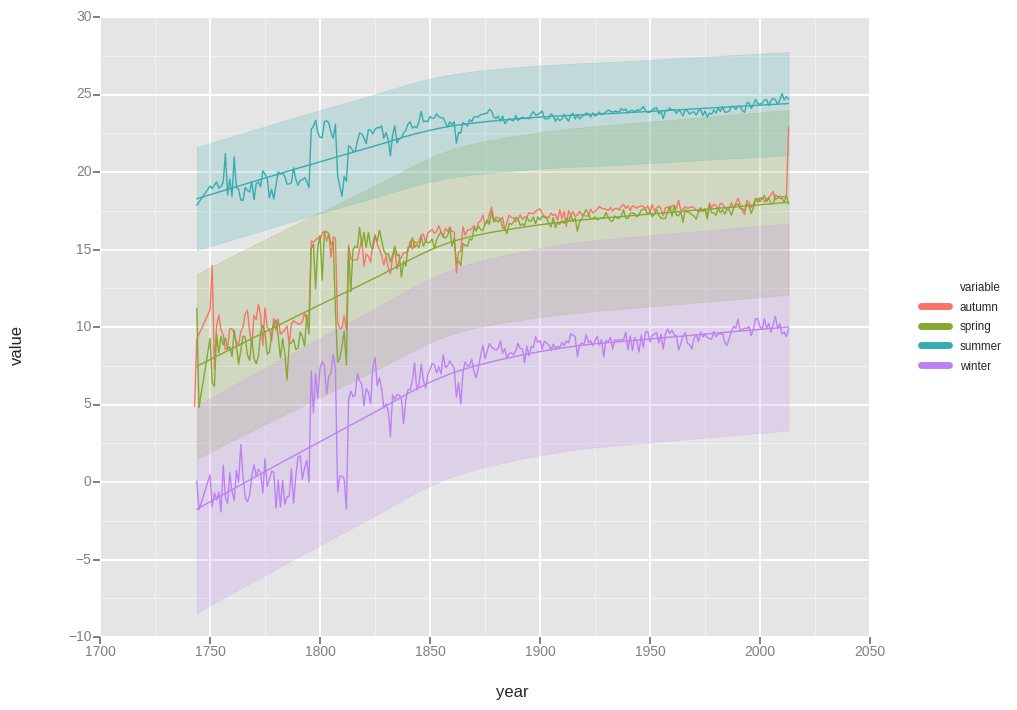

<ggplot: (8752052330493)>

In [214]:
gg = pd.melt(seasons, id_vars="year")
ggplot(gg, aes(x='year', y='value', color='variable')) + \
    geom_line() + stat_smooth(fullrange= 'TRUE')

    

In [283]:
sh = sh[['dt', 'AverageTemperature']]
sh['dt'] = pd.to_datetime(sh['dt'])
sh['year'] = sh['dt'].map(lambda x: x.year)
sh['month'] = sh['dt'].map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'
    
min_year = sh['year'].min()
max_year = sh['year'].max()
years = range(min_year, max_year + 1)

sh['season'] = sh['month'].apply(get_season)

spring_temps = []
summer_temps = []
autumn_temps = []
winter_temps = []

for year in years:
    curr_years_data = sh[sh['year'] == year]
    spring_temps.append(curr_years_data[curr_years_data['season'] == 'spring']['AverageTemperature'].mean())
    summer_temps.append(curr_years_data[curr_years_data['season'] == 'summer']['AverageTemperature'].mean())
    autumn_temps.append(curr_years_data[curr_years_data['season'] == 'autumn']['AverageTemperature'].mean())
    winter_temps.append(curr_years_data[curr_years_data['season'] == 'winter']['AverageTemperature'].mean())

sh.head()

,dt,AverageTemperature,year,month,season
78638,1841-01-01,21.432,1841,1,winter
78639,1841-02-01,22.087,1841,2,winter
78640,1841-03-01,18.859,1841,3,spring
78641,1841-04-01,15.033,1841,4,spring
78642,1841-05-01,12.864,1841,5,spring


In [284]:
seasons = pd.DataFrame(
    {'spring': spring_temps,
     'summer': summer_temps,
     'autumn': autumn_temps,
     'winter': winter_temps,
    })
seasons['year'] = years
seasons.head()

,autumn,spring,summer,winter,year
0,21.912407,23.050852,19.582722,24.948926,1787
1,22.328037,21.071222,20.952000,21.569333,1788
2,21.763815,23.216333,20.302667,24.577667,1789
3,21.593593,22.799778,20.077000,25.044630,1790
4,22.336963,23.370333,20.291370,25.309222,1791


/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/usr/local/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


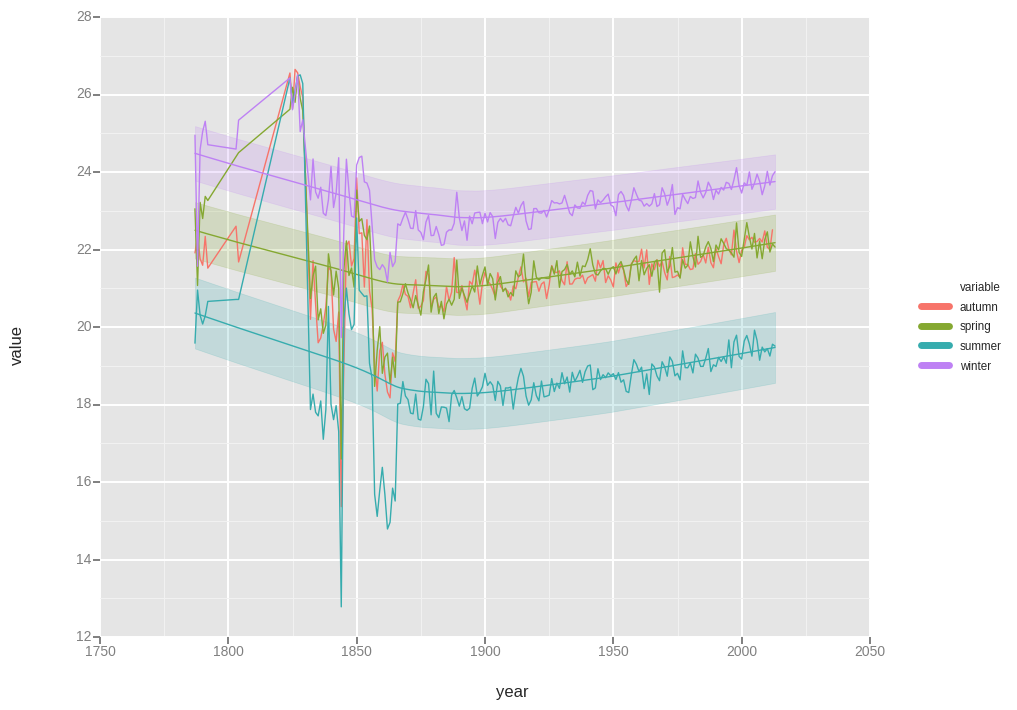

<ggplot: (-9223363284882472588)>

In [286]:
gg = pd.melt(seasons, id_vars="year")
ggplot(gg, aes(x='year', y='value', color='variable')) + \
    geom_line() + stat_smooth(fullrange= 'TRUE')


That's a lot of uncertainty near the beginning. Notice that the seasons are flipped from the northern hempisphere. And, the temperatures are still rising. 

For those interested, here are a couple tables showing which major cities were the hottest, and coldest in 2013. These aren't particularly interesting, as it's just one year. (This data only goes to 2013)

In [291]:
dfTempByMajorCity = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv',index_col='dt',parse_dates=[0])
dfTempByMajorCity[dfTempByMajorCity.index.year == 2013][['City','Country','AverageTemperature']].groupby(['City','Country'])\
.mean().sort_values('AverageTemperature',ascending=False).head(20)

,,AverageTemperature
City,Country,
Umm Durman,Sudan,30.650500
Madras,India,30.411750
Bangkok,Thailand,28.984750
Jiddah,Saudi Arabia,28.875875
Hyderabad,India,28.851250
Ho Chi Minh City,Vietnam,28.455000
Rangoon,Burma,28.038125
Mogadishu,Somalia,27.941375
Manila,Philippines,27.869000


In [292]:
dfTempByMajorCity[dfTempByMajorCity.index.year == 2013][['City','Country','AverageTemperature']].groupby(['City','Country'])\
.mean().sort_values('AverageTemperature',ascending=True).head(20)

,,AverageTemperature
City,Country,
Harbin,China,5.616875
Santiago,Chile,5.938125
Saint Petersburg,Russia,6.058750
Moscow,Russia,6.798875
Changchun,China,6.938500
Montreal,Canada,7.860333
Toronto,Canada,8.459444
Shenyang,China,9.304875
London,United Kingdom,9.907250


<h4>If we wanted to make a nice bar plot showing the average temperature in each country, ggplot proves to be a hassle. Seaborn knows how to do this easily given just two lists. <h4>

In [287]:
tcountry = pd.read_csv('GlobalLandTemperaturesByCountry.csv',index_col='dt',parse_dates=[0])
#countries is a series here
countries = tcountry['Country'].unique()

averagetemp = []


for country in countries:
    averagetemp.append(tcountry[tcountry['Country'] == country]['AverageTemperature'].mean())
    
avgtempres = []
rescountries = []

#there is some missing data, so we can go through the avg temp list,
#and if there is a NaN, skip it, otherwise add it to a new list
for i in range(len(averagetemp)):
    if not np.isnan(averagetemp[i]):
        avgtempres.append(averagetemp[i])
        rescountries.append(countries[i])

#here I created a data frame from the lists, hoping to use ggplot, but to no avail.
countrytemp = pd.DataFrame(
    {'countries': rescountries,
     'avgtemp': avgtempres
    })
countrytemp = countrytemp.sort_values('avgtemp')
countrytemp = countrytemp.reset_index()
countrytemp = countrytemp[['avgtemp','countries']]
countrytemp.head()


,avgtemp,countries
0,-18.587458,Greenland
1,-18.053051,Denmark
2,-7.448028,Svalbard And Jan Mayen
3,-5.521882,Russia
4,-5.216659,Canada


As much as I tried, I was unable to nicely graph the above dataframe with ggplot, but seaborn comes equipped with a nice 'coolwarm' palette anyway, so it works well with temperatures. 

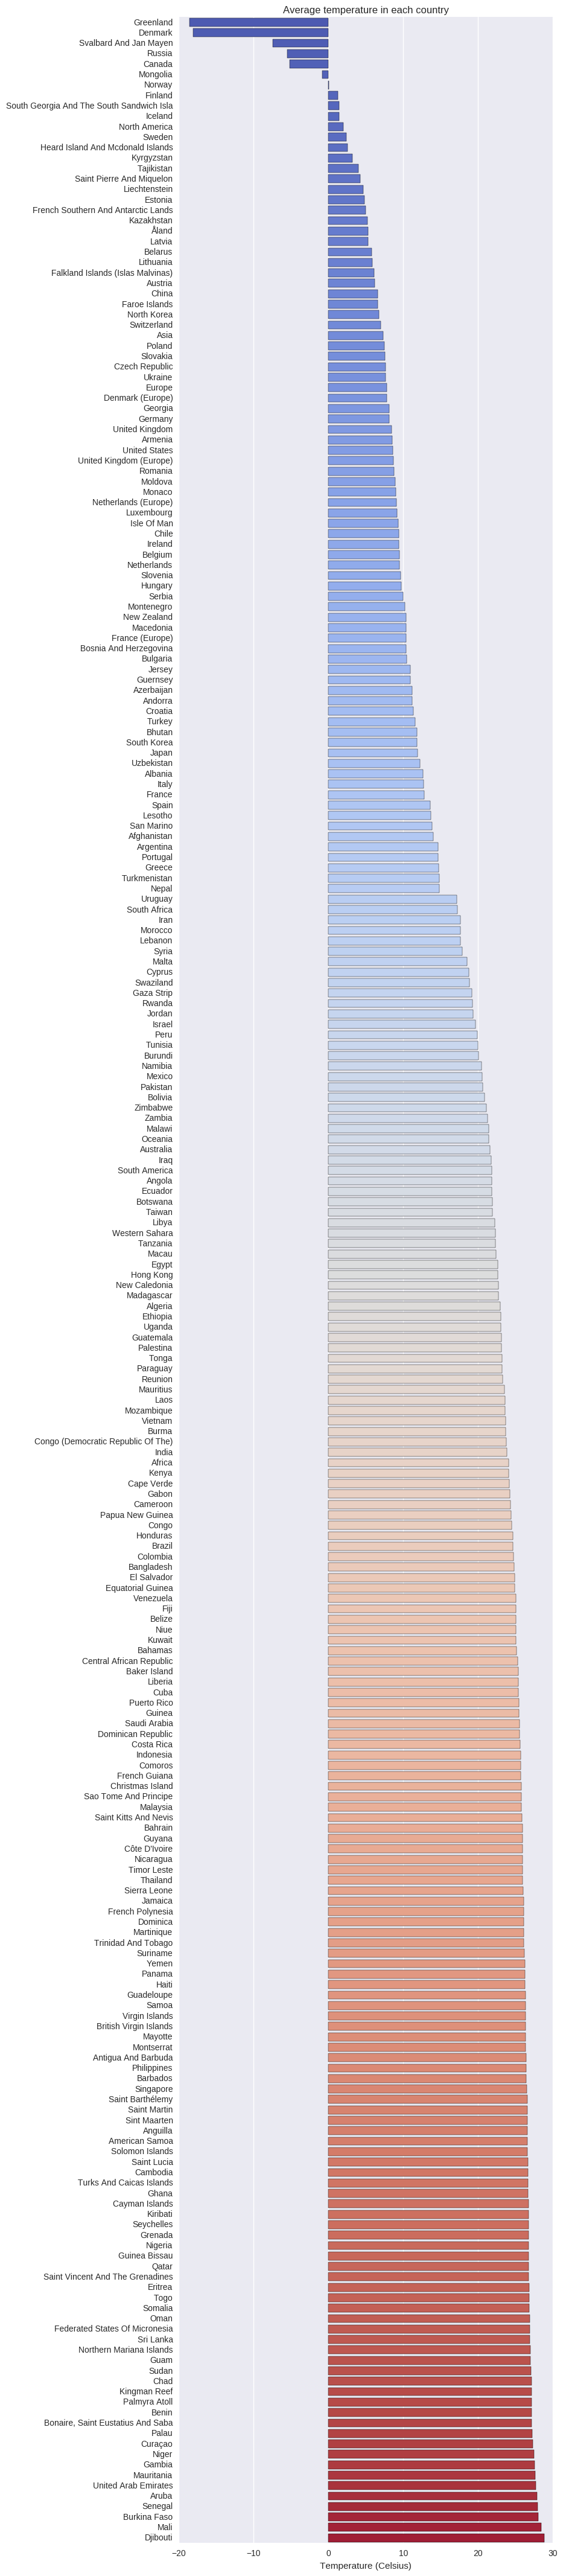

In [172]:
f, ax = matplotlib.pyplot.subplots(figsize=(8, 54))
sbn.barplot(x=countrytemp['avgtemp'], y=countrytemp['countries'], palette=sbn.color_palette("coolwarm", len(avgtempres)), ax=ax)

texts = ax.set(ylabel="", xlabel="Temperature (Celsius)", title="Average temperature in each country")

If I were to keep looking into this data set, I would see how temperature uncertainty changes over time using the uncertainty column. Using that data, we can use ggplot to plot a density graph of uncertainties. Although, it is relatively easy to see an artificial uncertainty by looking at the seasons graphs. Once the lines start to smooth out, the data becomes much more 'certain'. It appears as though this happens around 1850. 